# Edge Detection in Spatial Domain
Using OpenCV only for reading the image.
All edge detection filters are implemented manually using NumPy.

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,8)

## Read Image (OpenCV only for reading)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

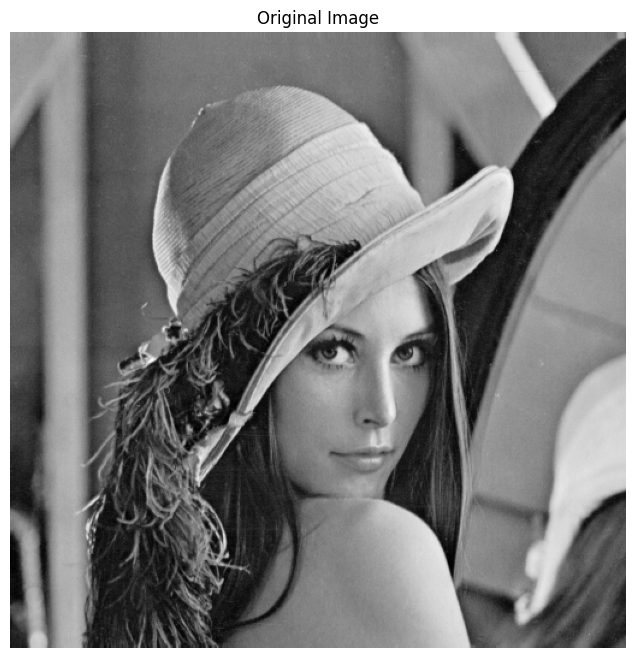

In [16]:
img = cv2.imread('input.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype(np.float32)

plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

## Helper Functions

In [17]:
def pad_image(image, pad):
    return np.pad(image, ((pad, pad), (pad, pad)), mode='reflect')

def convolve(image, kernel):
    k = kernel.shape[0]
    pad = k // 2
    padded = pad_image(image, pad)
    output = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+k, j:j+k]
            output[i,j] = np.sum(region * kernel)

    return output

def normalize(image):
    image = np.abs(image)
    return np.clip(image, 0, 255)

## 1. Roberts Operator

In [18]:
roberts_x = np.array([[1, 0],
                      [0,-1]])

roberts_y = np.array([[0, 1],
                      [-1,0]])

rx = convolve(img, roberts_x)
ry = convolve(img, roberts_y)
roberts = normalize(np.sqrt(rx**2 + ry**2))

## 2. Prewitt Operator

In [19]:
prewitt_x = np.array([[-1,0,1],
                      [-1,0,1],
                      [-1,0,1]])

prewitt_y = np.array([[1,1,1],
                      [0,0,0],
                      [-1,-1,-1]])

px = convolve(img, prewitt_x)
py = convolve(img, prewitt_y)
prewitt = normalize(np.sqrt(px**2 + py**2))

## 3. Sobel Operator

In [20]:
sobel_x = np.array([[-1,0,1],
                    [-2,0,2],
                    [-1,0,1]])

sobel_y = np.array([[1,2,1],
                    [0,0,0],
                    [-1,-2,-1]])

sx = convolve(img, sobel_x)
sy = convolve(img, sobel_y)
sobel = normalize(np.sqrt(sx**2 + sy**2))

## 4. Laplacian Operator

In [21]:
laplacian_kernel = np.array([[0,-1,0],
                             [-1,4,-1],
                             [0,-1,0]])

laplacian = normalize(convolve(img, laplacian_kernel))

## Display All Results

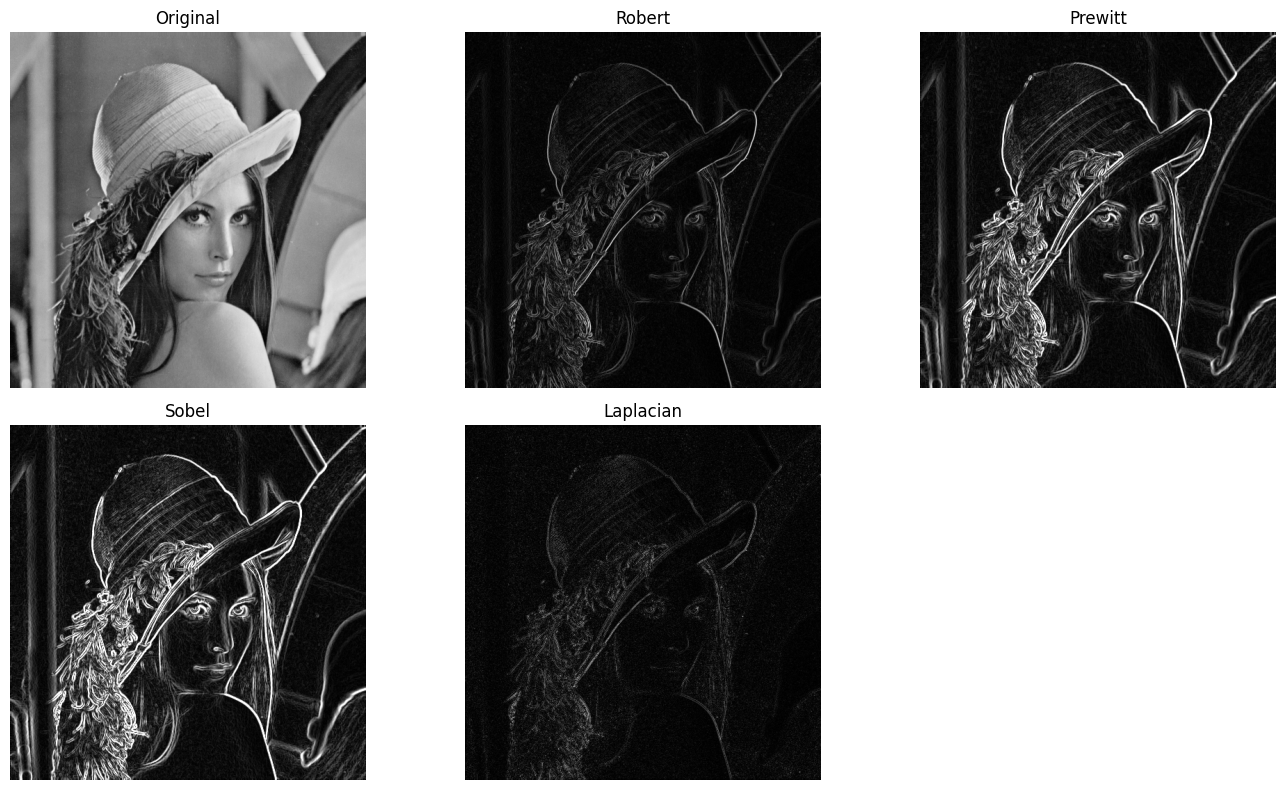

In [23]:
titles = ['Original', 'Robert', 'Prewitt', 'Sobel', 'Laplacian']
images = [img,  roberts, prewitt, sobel, laplacian]

plt.figure(figsize=(14,8))
for i in range(len(images)):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

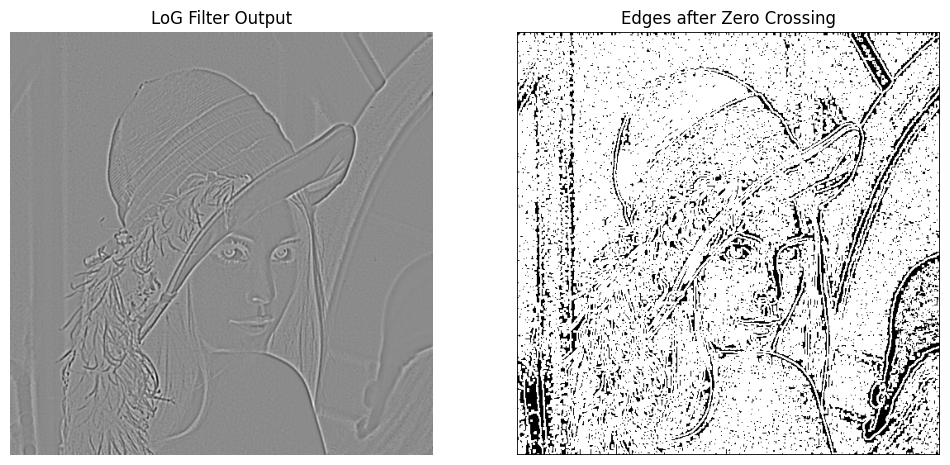

In [25]:
import numpy as np

def log_kernel(k=7, sigma=1.0):
    """Generate a Laplacian of Gaussian kernel."""
    ax = np.arange(-k//2 + 1., k//2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    norm = (xx**2 + yy**2) / (2*sigma**2)
    kernel = -1/(np.pi*sigma**4) * (1 - norm) * np.exp(-norm)
    kernel -= kernel.mean()  # normalize to sum=0
    return kernel

# Example: 7x7 kernel, sigma=1.0
kernel = log_kernel(k=7, sigma=1.0)

def pad_image(image, pad):
    return np.pad(image, ((pad,pad),(pad,pad)), mode='reflect')

def convolve(image, kernel):
    k = kernel.shape[0]
    pad = k // 2
    padded = pad_image(image, pad)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+k, j:j+k]
            output[i,j] = np.sum(region * kernel)
    return output

log_img = convolve(img, kernel)

# Zero-crossing detection for edges
def zero_crossing(image, threshold=0.0):
    zc = np.zeros_like(image)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            patch = image[i-1:i+2, j-1:j+2]
            p = image[i,j]
            if ((p > 0 and np.min(patch) < 0) or (p < 0 and np.max(patch) > 0)):
                if np.max(np.abs(patch)) > threshold:
                    zc[i,j] = 255
    return zc

edges = zero_crossing(log_img, threshold=0.01 * np.max(np.abs(log_img)))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(log_img, cmap='gray')
plt.title("LoG Filter Output")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(edges, cmap='gray')
plt.title("Edges after Zero Crossing")
plt.axis("off")

plt.show()

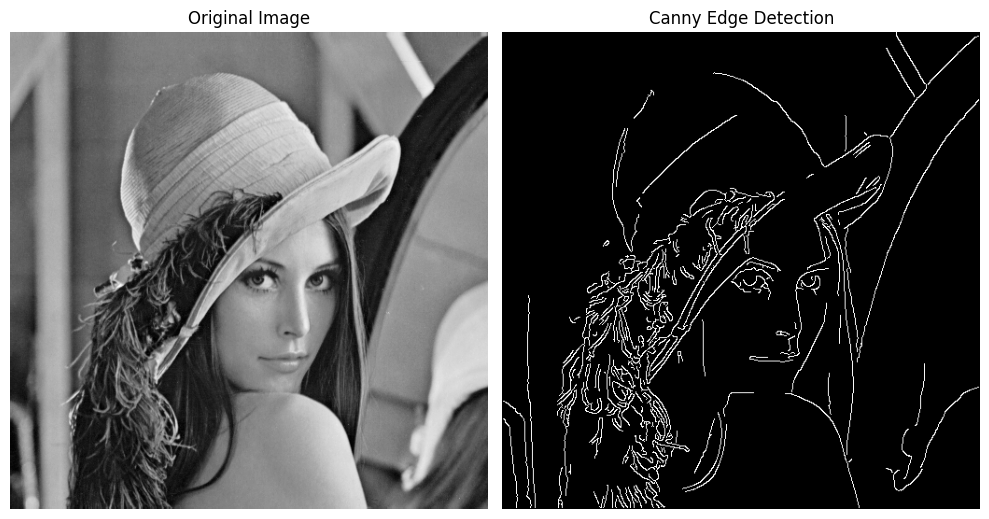

In [28]:
#canny edge 

def canny_edge_detection(img, low_threshold=20, high_threshold=50):
    # 1. Smoothing (Gaussian Blur)
    gaussian_kernel = np.array([[1, 4, 7, 4, 1],
                                [4, 16, 26, 16, 4],
                                [7, 26, 41, 26, 7],
                                [4, 16, 26, 16, 4],
                                [1, 4, 7, 4, 1]]) / 273
    smoothed_img = convolve(img, gaussian_kernel)

    # 2. Finding Gradients (using Sobel kernels)
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = convolve(smoothed_img, Kx)
    Iy = convolve(smoothed_img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    # 3. Non-Maximum Suppression
    M, N = G.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M-1):
        for j in range(1, N-1):
            q = 255
            r = 255
            
            # angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = G[i, j+1]
                r = G[i, j-1]
            # angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = G[i+1, j-1]
                r = G[i-1, j+1]
            # angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = G[i+1, j]
                r = G[i-1, j]
            # angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = G[i-1, j-1]
                r = G[i+1, j+1]

            if (G[i,j] >= q) and (G[i,j] >= r):
                Z[i,j] = G[i,j]
            else:
                Z[i,j] = 0

    # 4. Double Threshold
    res = np.zeros((M, N), dtype=np.int32)
    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(Z >= high_threshold)
    zeros_i, zeros_j = np.where(Z < low_threshold)
    weak_i, weak_j = np.where((Z <= high_threshold) & (Z >= low_threshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    # 5. Hysteresis (Edge Tracking)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (res[i,j] == weak):
                if ((res[i+1, j-1] == strong) or (res[i+1, j] == strong) or (res[i+1, j+1] == strong)
                    or (res[i, j-1] == strong) or (res[i, j+1] == strong)
                    or (res[i-1, j-1] == strong) or (res[i-1, j] == strong) or (res[i-1, j+1] == strong)):
                    res[i,j] = strong
                else:
                    res[i,j] = 0
    return res

# Usage:
canny_edges = canny_edge_detection(img, low_threshold=20, high_threshold=60)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(canny_edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

plt.tight_layout()
plt.show()